# Análise de técnicas de Data Aumentation na geração de um banco de soldas para classificação utilizando a DCT

In [1]:
import cv2 as cv
print("OpenCV: ", cv.__version__)
import numpy as np
print("numpy: ", np.__version__)
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib widget

OpenCV:  4.7.0
numpy:  1.24.2


Primeiramente vamos carregar as imagens que temos, uma de cada classe, converter em imagens em tons de cinza e armazenar numa lista. 

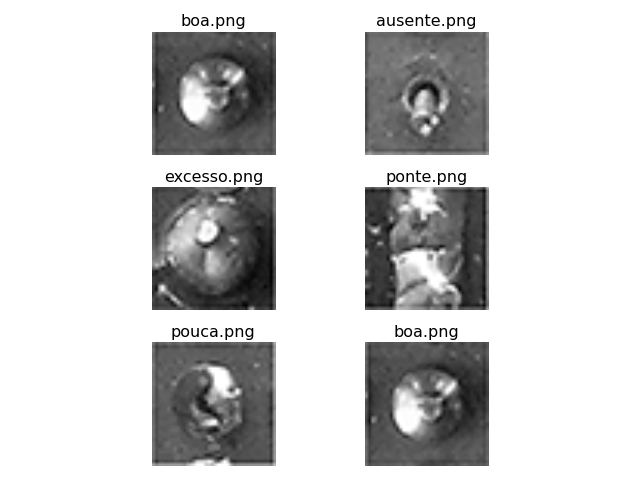

In [4]:
# Nome dos arquivos com as imagens boas
imgNameList = ['boa.png', 'ausente.png', 'excesso.png', 
           'ponte.png', 'pouca.png']
# Carregando as imagens e guardando numa lista
imgList = []
for imgName in imgNameList:
    imgFile = "/Users/evalero/Library/CloudStorage/GoogleDrive-valero.esbel@gmail.com/Meu Drive/Desktop/Proghramação/Git/soldas_dt_aug/img_src/" + imgName
    img = cv.imread(imgFile)
    imgG = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    imgList.append(imgG)
fig, ax = plt.subplots(3,2)
for i in range(3):
    for j in range(2):
        index = (2*i+j) % 5
        ax[i,j].imshow(imgList[index], cmap='gray')
        ax[i,j].set_title(imgNameList[index])
        ax[i,j].axis('off')
        plt.tight_layout()

Agora vamos implementar o extrator de características que queremos utilizar para avaliar nosso processo de data augmentation. Neste casso vamos utilizar a transformada discreta do cosseno (DCT). A forma de calcular a transformada, para ser utilizada como extrator de características, pode ser melhor discutida posteriormente. 

In [ ]:
class DctService():
    def __init__(self):
        pass

    ''' 
    Função que aplica o filtro DCT na imagem. Entrada uma imagem BGR
    '''
    def dct_filter(self, img, chanels = 'GRAY', show = False):
        if chanels == 'BGR':
            gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        elif chanels == 'RGB':
            gray_img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        else:
            gray_img = img
        lut = np.arange(1, 257, dtype="float64")     
        lut = np.log(lut)
        #lut = np.asarray([np.log(i, 2) for i in (np.arange(0, 256) + 1)], "float64")
        img_log = cv.LUT(gray_img, lut)
        dctImg = cv.dct(img_log) # Transformada da imagem
        # Agora vamos normalizar a imagem para que os valores fiquem entre 0 e 255
        dctImage = cv.normalize(dctImg, None, 0, 255, cv.NORM_MINMAX, cv.CV_8UC1)
        # A função pode retornar os dois formatos
        if show: 
            return dctImage  # para visualizar
        else:
            return dctImg   # para processar

    def operacao_dct(self, img_solda):
        soma = np.sum(img_solda)
        media = np.mean(img_solda)
        desvio = np.std(img_solda)
        minValue = np.min(img_solda)
        maxValue = np.max(img_solda)
        return soma, media, desvio, minValue, maxValue
        #return desvio, minValue

    def dctSum(self, img):
        return np.array(self.operacao_dct(img))


Podemos então aplicar o extrator de características e, com o objetivo de visualizar o resultado, podemos armazenar as imagens. As imagens para análise serão guardadas posteriormente na lista. 

In [ ]:
fig, ax = plt.subplots(3,2)
imgDCT = []
index = 0
for img in imgList:
    imgDCT.append(DctService().dct_filter(img))
    img = DctService().dct_filter(img, show=True)
    i = index // 2
    j = index % 2
    ax[i,j].imshow(img[:5, 0:5], cmap='gray')
    ax[i,j].set_title(imgNameList[index%5])
    ax[i,j].axis('off')
    plt.tight_layout()
    index += 1    
img = DctService().dct_filter(imgList[0], show=True)
ax[2,1].imshow(img[:5, 0:5], cmap='gray')
ax[2,1].set_title(imgNameList[0])
ax[2,1].axis('off')
plt.tight_layout()

Visualmente não tem diferença significativa entre as imagens geradas. Vamos analisar então os valores dos vetores de características considerando, inicialmente todos os parâmetros. 

In [ ]:
print("[ Soma, Média, Desvio, Min, Max]")
vetCar = np.zeros((4098, 5))
index = 0;
for img in imgDCT:
    vetCar[index,:] = DctService().operacao_dct(img)
    print("[ %.3f" % (vetCar[index,0]), end='')
    for val in vetCar[index, 1:]:
        print(", %.3f" % (val), end='')
    print(" ]")
    index += 1

A soma e a média são métricas linearmente dependentes, devido ao fato de que as imagens são dos mesmo tamanho. Entretanto, em casos reais devem ser análises de imagens de tamanhos diversos. Vamos excluir então a soma, por enquanto, e mostrar em gráficos as projeções destes vetores.  

In [ ]:
#ax[axi, axj].scatter(soma, std, color=colors[i-1])
colors = ['red', 'blue', 'green', 'black', 'yellow']
fig, ax = plt.subplots(3,2)
ax[0,0].scatter(vetCar[:5, 1], vetCar[:5, 2], color=colors)
ax[0,0].set_title('Média x Desvio')
ax[0,0].set_xlabel('Média')
ax[0,0].set_ylabel('Desvio')
ax[0,1].scatter(vetCar[:5, 1], vetCar[:5, 3], color=colors)
ax[0,1].set_title('Média x Min')
ax[0,1].set_xlabel('Média')
ax[0,1].set_ylabel('Min')
ax[1,0].scatter(vetCar[:5, 1], vetCar[:5, 4], color=colors)
ax[1,0].set_title('Média x Max')
ax[1,0].set_xlabel('Média')
ax[1,0].set_ylabel('Max')
ax[1,1].scatter(vetCar[:5, 2], vetCar[:5, 3], color=colors)
ax[1,1].set_title('Desvio x Min')
ax[1,1].set_xlabel('Desvio')    
ax[1,1].set_ylabel('Min')
ax[2,0].scatter(vetCar[:5, 2], vetCar[:5, 4], color=colors)
ax[2,0].set_title('Desvio x Max')
ax[2,0].set_xlabel('Desvio')
ax[2,0].set_ylabel('Max')
ax[2,1].scatter(vetCar[:5, 3], vetCar[:5, 4], color=colors)
ax[2,1].set_title('Min x Max')
ax[2,1].set_xlabel('Min')
ax[2,1].set_ylabel('Max')
plt.tight_layout()


# Testando as técnicas de Data AUmentation

## Flipping

Inicialmente vamos trabalhar a técnica de flipping utilizando os recursos disponíveis na biblioteca OpenCL. A função flip permite aplicar esta técnica na direção vertical, na horizontal ou em ambas. Vamos gerar então três imagens novas, com base nas images originais.  

In [ ]:
imgFlipList = []
index = 5
print("[ Soma, Média, Desvio, Min, Max]")
for img in imgList:
    # Flip vertical
    imgFlip = cv.flip(img, 0)
    #imgFlip_H = cv.flip(imgG, 1)
    #imgFlip_VH = cv.flip(imgG, -1)

    imgFlipList.append(imgFlip)
    imgFlip = DctService().dct_filter(imgFlip)
    vetCar[index,:] = DctService().operacao_dct(imgFlip)
    print("[ %.3f" % (vetCar[index,0]), end='')
    for val in vetCar[index, 1:]:
        print(", %.3f" % (val), end='')
    print(" ]")
    index += 1


fig, ax = plt.subplots(3,2)
ax[0,0].scatter(vetCar[5:10, 1], vetCar[5:10, 2], color=colors)
ax[0,0].scatter(vetCar[0:5, 1], vetCar[0:5, 2], color=colors)
ax[0,0].set_title('Média x Desvio')
ax[0,0].set_xlabel('Média')
ax[0,0].set_ylabel('Desvio')
ax[0,1].scatter(vetCar[5:10, 1], vetCar[5:10, 3], color=colors)
ax[0,1].scatter(vetCar[0:5, 1], vetCar[0:5, 3], color=colors)
ax[0,1].set_title('Média x Min')
ax[0,1].set_xlabel('Média')
ax[0,1].set_ylabel('Min')
ax[1,0].scatter(vetCar[5:10, 1], vetCar[5:10, 4], color=colors)
ax[1,0].scatter(vetCar[0:5, 1], vetCar[0:5, 4], color=colors)
ax[1,0].set_title('Média x Max')
ax[1,0].set_xlabel('Média')
ax[1,0].set_ylabel('Max')
ax[1,1].scatter(vetCar[5:10, 2], vetCar[5:10, 3], color=colors)
ax[1,1].scatter(vetCar[0:5, 2], vetCar[0:5, 3], color=colors)
ax[1,1].set_title('Desvio x Min')
ax[1,1].set_xlabel('Desvio')    
ax[1,1].set_ylabel('Min')
ax[2,0].scatter(vetCar[5:10, 2], vetCar[5:10, 4], color=colors)
ax[2,0].scatter(vetCar[0:5, 2], vetCar[0:5, 4], color=colors)
ax[2,0].set_title('Desvio x Max')
ax[2,0].set_xlabel('Desvio')
ax[2,0].set_ylabel('Max')
ax[2,1].scatter(vetCar[5:10, 3], vetCar[5:10, 4], color=colors)
ax[2,1].scatter(vetCar[0:5, 3], vetCar[0:5, 4], color=colors)
ax[2,1].set_title('Min x Max')
ax[2,1].set_xlabel('Min')
ax[2,1].set_ylabel('Max')
plt.tight_layout()    



In [ ]:
index = 10
print("[ Soma, Média, Desvio, Min, Max]")
for img in imgList:
    # Flip vertical
    #imgFlip = cv.flip(img, 0)
    imgFlip = cv.flip(img, 1)
    #imgFlip_VH = cv.flip(imgG, -1)

    imgFlipList.append(imgFlip)
    imgFlip = DctService().dct_filter(imgFlip)
    vetCar[index,:] = DctService().operacao_dct(imgFlip)
    print("[ %.3f" % (vetCar[index,0]), end='')
    for val in vetCar[index, 1:]:
        print(", %.3f" % (val), end='')
    print(" ]")
    index += 1


fig, ax = plt.subplots(3,2)
ax[0,0].scatter(vetCar[10:15, 1], vetCar[10:15, 2], color=colors)
ax[0,0].scatter(vetCar[5:10, 1], vetCar[5:10, 2], color=colors)
ax[0,0].scatter(vetCar[0:5, 1], vetCar[0:5, 2], color=colors)
ax[0,0].set_title('Média x Desvio')
ax[0,0].set_xlabel('Média')
ax[0,0].set_ylabel('Desvio')
ax[0,1].scatter(vetCar[10:15, 1], vetCar[10:15, 3], color=colors)
ax[0,1].scatter(vetCar[5:10, 1], vetCar[5:10, 3], color=colors)
ax[0,1].scatter(vetCar[0:5, 1], vetCar[0:5, 3], color=colors)
ax[0,1].set_title('Média x Min')
ax[0,1].set_xlabel('Média')
ax[0,1].set_ylabel('Min')
ax[1,0].scatter(vetCar[10:15, 1], vetCar[10:15, 4], color=colors)
ax[1,0].scatter(vetCar[5:10, 1], vetCar[5:10, 4], color=colors)
ax[1,0].scatter(vetCar[0:5, 1], vetCar[0:5, 4], color=colors)
ax[1,0].set_title('Média x Max')
ax[1,0].set_xlabel('Média')
ax[1,0].set_ylabel('Max')
ax[1,1].scatter(vetCar[10:15, 2], vetCar[10:15, 3], color=colors)
ax[1,1].scatter(vetCar[5:10, 2], vetCar[5:10, 3], color=colors)
ax[1,1].scatter(vetCar[0:5, 2], vetCar[0:5, 3], color=colors)
ax[1,1].set_title('Desvio x Min')
ax[1,1].set_xlabel('Desvio')    
ax[1,1].set_ylabel('Min')
ax[2,0].scatter(vetCar[10:15, 2], vetCar[10:15, 4], color=colors)
ax[2,0].scatter(vetCar[5:10, 2], vetCar[5:10, 4], color=colors)
ax[2,0].scatter(vetCar[0:5, 2], vetCar[0:5, 4], color=colors)
ax[2,0].set_title('Desvio x Max')
ax[2,0].set_xlabel('Desvio')
ax[2,0].set_ylabel('Max')
ax[2,1].scatter(vetCar[10:15, 3], vetCar[10:15, 4], color=colors)
ax[2,1].scatter(vetCar[5:10, 3], vetCar[5:10, 4], color=colors)
ax[2,1].scatter(vetCar[0:5, 3], vetCar[0:5, 4], color=colors)
ax[2,1].set_title('Min x Max')
ax[2,1].set_xlabel('Min')
ax[2,1].set_ylabel('Max')
plt.tight_layout()    


In [ ]:
index = 15
print("[ Soma, Média, Desvio, Min, Max]")
for img in imgList:
    # Flip vertical
    #imgFlip = cv.flip(img, 0)
    #imgFlip = cv.flip(img, 1)
    imgFlip = cv.flip(img, -1)

    imgFlipList.append(imgFlip)
    imgFlip = DctService().dct_filter(imgFlip)
    vetCar[index,:] = DctService().operacao_dct(imgFlip)
    print("[ %.3f" % (vetCar[index,0]), end='')
    for val in vetCar[index, 1:]:
        print(", %.3f" % (val), end='')
    print(" ]")
    index += 1

fig, ax = plt.subplots(3,2)
ax[0,0].scatter(vetCar[15:20, 1], vetCar[15:20, 2], color=colors)
ax[0,0].scatter(vetCar[10:15, 1], vetCar[10:15, 2], color=colors)
ax[0,0].scatter(vetCar[5:10, 1], vetCar[5:10, 2], color=colors)
ax[0,0].scatter(vetCar[0:5, 1], vetCar[0:5, 2], color=colors)
ax[0,0].set_title('Média x Desvio')
ax[0,0].set_xlabel('Média')
ax[0,0].set_ylabel('Desvio')
ax[0,1].scatter(vetCar[15:20, 1], vetCar[15:20, 3], color=colors)
ax[0,1].scatter(vetCar[10:15, 1], vetCar[10:15, 3], color=colors)
ax[0,1].scatter(vetCar[5:10, 1], vetCar[5:10, 3], color=colors)
ax[0,1].scatter(vetCar[0:5, 1], vetCar[0:5, 3], color=colors)
ax[0,1].set_title('Média x Min')
ax[0,1].set_xlabel('Média')
ax[0,1].set_ylabel('Min')
ax[1,0].scatter(vetCar[15:20, 1], vetCar[15:20, 4], color=colors)
ax[1,0].scatter(vetCar[10:15, 1], vetCar[10:15, 4], color=colors)
ax[1,0].scatter(vetCar[5:10, 1], vetCar[5:10, 4], color=colors)
ax[1,0].scatter(vetCar[0:5, 1], vetCar[0:5, 4], color=colors)
ax[1,0].set_title('Média x Max')
ax[1,0].set_xlabel('Média')
ax[1,0].set_ylabel('Max')
ax[1,1].scatter(vetCar[15:20, 2], vetCar[15:20, 3], color=colors)
ax[1,1].scatter(vetCar[10:15, 2], vetCar[10:15, 3], color=colors)
ax[1,1].scatter(vetCar[5:10, 2], vetCar[5:10, 3], color=colors)
ax[1,1].scatter(vetCar[0:5, 2], vetCar[0:5, 3], color=colors)
ax[1,1].set_title('Desvio x Min')
ax[1,1].set_xlabel('Desvio')    
ax[1,1].set_ylabel('Min')
ax[2,0].scatter(vetCar[15:20, 2], vetCar[15:20, 4], color=colors)
ax[2,0].scatter(vetCar[10:15, 2], vetCar[10:15, 4], color=colors)
ax[2,0].scatter(vetCar[5:10, 2], vetCar[5:10, 4], color=colors)
ax[2,0].scatter(vetCar[0:5, 2], vetCar[0:5, 4], color=colors)
ax[2,0].set_title('Desvio x Max')
ax[2,0].set_xlabel('Desvio')
ax[2,0].set_ylabel('Max')
ax[2,1].scatter(vetCar[15:20, 3], vetCar[15:20, 4], color=colors)
ax[2,1].scatter(vetCar[10:15, 3], vetCar[10:15, 4], color=colors)
ax[2,1].scatter(vetCar[5:10, 3], vetCar[5:10, 4], color=colors)
ax[2,1].scatter(vetCar[0:5, 3], vetCar[0:5, 4], color=colors)
ax[2,1].set_title('Min x Max')
ax[2,1].set_xlabel('Min')
ax[2,1].set_ylabel('Max')
plt.tight_layout()  

In [ ]:
fig, ax = plt.subplots(3,2)
colors = [['red', 'red', 'red', 'red'], 
          ['blue', 'blue', 'blue', 'blue'],
          ['green', 'green', 'green', 'green'],
          ['black', 'black', 'black', 'black'],
          ['yellow', 'yellow', 'yellow', 'yellow']]
i = 0
for img_name in imgList:
    soma = []
    std = []
    imgBoa = cv.imread(img_name)
    imgG = cv.cvtColor(imgBoa, cv.COLOR_BGR2GRAY)
    dct_img = DctService().dct_filter(imgG, chanels='GRAY')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    
    imgFlip_V = cv.flip(imgG, 0)
    imgFlip_H = cv.flip(imgG, 1)
    imgFlip_VH = cv.flip(imgG, -1)

    dct_FV = DctService().dct_filter(imgFlip_V, chanels='GRAY')
    dct_FH = DctService().dct_filter(imgFlip_H, chanels='GRAY')
    dct_FVH = DctService().dct_filter(imgFlip_VH, chanels='GRAY')

    vetCaract_FV = DctService().dctSum(dct_FV)
    soma.append(vetCaract_FV[1])
    std.append(vetCaract_FV[2])
    vetCaract_FH = DctService().dctSum(dct_FH)
    soma.append(vetCaract_FH[1])
    std.append(vetCaract_FH[2])
    vetCaract_FVH = DctService().dctSum(dct_FVH)
    soma.append(vetCaract_FVH[1])
    std.append(vetCaract_FVH[2])
    ax[0, 0].scatter(soma, std, color=colors[i])
    i+= 1
    axi = i//2
    axj = i%2
    ax[axi, axj].scatter(soma, std, color=colors[i-1])


    

In [ ]:

imgBoa = cv.imread(imgList[0])
imgG = cv.cvtColor(imgBoa, cv.COLOR_BGR2GRAY)
altura, largura = imgG.shape[:2]
centro = (largura / 2, altura / 2) #ponto no centro da figura
M_Rot = cv.getRotationMatrix2D(centro, 10, 1.0)
imgR10 = cv.warpAffine(imgG, M_Rot, (largura, altura),
                        flags= cv.INTER_CUBIC,
                        borderMode=cv.BORDER_REPLICATE)
fig, ax = plt.subplots(1,2)
ax[0].imshow(imgG, cmap='gray')
ax[0].set_title('Imagem Solda Boa')
ax[0].axis('off')
ax[1].imshow(imgR10, cmap='gray')
ax[1].set_title('Rotação 10')
ax[1].axis('off')

In [ ]:
dct_img = DctService().dct_filter(imgR10, chanels='GRAY')
fig, ax = plt.subplots(1,2)
ax[0].imshow(imgR10, cmap='gray')
ax[0].set_title('Imagem Solda Boa')
ax[0].axis('off')
ax[1].imshow(dct_img, cmap='gray')
ax[1].set_title('DCT')
ax[1].axis('off')

In [ ]:
fig, ax = plt.subplots(3,2)
colors = ['red', 'blue', 'green', 'black', 'yellow']
pCol = []
ang = [3, 6, 9, 12, 15, -15, -12, -9, -6, -3]
i = 0
for img_name in imgList:
    soma = []
    std = []
    pCol = []
    imgBoa = cv.imread(img_name)
    imgG = cv.cvtColor(imgBoa, cv.COLOR_BGR2GRAY)
    dct_img = DctService().dct_filter(imgG, chanels='GRAY')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])
    
    altura, largura = imgG.shape[:2]
    centro = (largura / 2, altura / 2) #ponto no centro da figura
    for alpha in ang:
        M_Rot = cv.getRotationMatrix2D(centro, alpha, 1.0)
        imgR = cv.warpAffine(imgG, M_Rot, (largura, altura),
                        flags= cv.INTER_CUBIC,
                        borderMode=cv.BORDER_REPLICATE)
        dct_img = DctService().dct_filter(imgR, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])

    imgFlip_V = cv.flip(imgG, 0)
    imgFlip_H = cv.flip(imgG, 1)
    imgFlip_VH = cv.flip(imgG, -1)

    dct_FV = DctService().dct_filter(imgFlip_V, chanels='GRAY')
    dct_FH = DctService().dct_filter(imgFlip_H, chanels='GRAY')
    dct_FVH = DctService().dct_filter(imgFlip_VH, chanels='GRAY')

    vetCaract_FV = DctService().dctSum(dct_FV)
    soma.append(vetCaract_FV[1])
    std.append(vetCaract_FV[2])
    pCol.append(colors[i])
    for alpha in ang:
        M_Rot = cv.getRotationMatrix2D(centro, alpha, 1.0)
        imgR = cv.warpAffine(imgFlip_V, M_Rot, (largura, altura),
                        flags= cv.INTER_CUBIC,
                        borderMode=cv.BORDER_REPLICATE)
        dct_img = DctService().dct_filter(imgR, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
    vetCaract_FH = DctService().dctSum(dct_FH)
    soma.append(vetCaract_FH[1])
    std.append(vetCaract_FH[2])
    pCol.append(colors[i])
    for alpha in ang:
        M_Rot = cv.getRotationMatrix2D(centro, alpha, 1.0)
        imgR = cv.warpAffine(imgFlip_H, M_Rot, (largura, altura),
                        flags= cv.INTER_CUBIC,
                        borderMode=cv.BORDER_REPLICATE)
        dct_img = DctService().dct_filter(imgR, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
    vetCaract_FVH = DctService().dctSum(dct_FVH)
    soma.append(vetCaract_FVH[1])
    std.append(vetCaract_FVH[2])
    pCol.append(colors[i])
    for alpha in ang:
        M_Rot = cv.getRotationMatrix2D(centro, alpha, 1.0)
        imgR = cv.warpAffine(imgFlip_VH, M_Rot, (largura, altura),
                        flags= cv.INTER_CUBIC,
                        borderMode=cv.BORDER_REPLICATE)
        dct_img = DctService().dct_filter(imgR, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
    ax[0, 0].scatter(soma, std, color=colors[i])
    i+= 1
    axi = i//2
    axj = i%2
    ax[axi, axj].scatter(soma, std, color=colors[i-1])

print(imgList)
print(colors)

In [ ]:
fig, ax = plt.subplots(3,2)
colors = ['red', 'blue', 'green', 'black', 'yellow']
pCol = []
ang = [3, 6, 9, 12, 15, -15, -12, -9, -6, -3]
i = 0
for img_name in imgList:
    soma = []
    std = []
    pCol = []
    imgBoa = cv.imread(img_name)
    imgG = cv.cvtColor(imgBoa, cv.COLOR_BGR2GRAY)
    dct_img = DctService().dct_filter(imgG, chanels='GRAY')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])

    imgN = imgG.copy() 
    mean=0
    st=0.7
    gauss = np.random.normal(mean,st,imgN.shape)
    gauss = gauss.astype('uint8')
    imgN = cv.add(imgN,gauss)
    imgN = cv.normalize(imgN, None, 0, 255, cv.NORM_MINMAX, cv.CV_8UC1)
    dct_img = DctService().dct_filter(imgN, chanels='GRAY')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])

    
    altura, largura = imgG.shape[:2]
    centro = (largura / 2, altura / 2) #ponto no centro da figura
    for alpha in ang:
        M_Rot = cv.getRotationMatrix2D(centro, alpha, 1.0)
        imgR = cv.warpAffine(imgG, M_Rot, (largura, altura),
                        flags= cv.INTER_CUBIC,
                        borderMode=cv.BORDER_REPLICATE)
        dct_img = DctService().dct_filter(imgR, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
        gauss = np.random.normal(mean,st,imgN.shape)
        gauss = gauss.astype('uint8')
        imgN = cv.add(imgR,gauss)
        imgN = cv.normalize(imgN, None, 0, 255, cv.NORM_MINMAX, cv.CV_8UC1)
        dct_img = DctService().dct_filter(imgN, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])

    imgFlip_V = cv.flip(imgG, 0)
    imgFlip_H = cv.flip(imgG, 1)
    imgFlip_VH = cv.flip(imgG, -1)

    dct_FV = DctService().dct_filter(imgFlip_V, chanels='GRAY')
    dct_FH = DctService().dct_filter(imgFlip_H, chanels='GRAY')
    dct_FVH = DctService().dct_filter(imgFlip_VH, chanels='GRAY')

    vetCaract_FV = DctService().dctSum(dct_FV)
    soma.append(vetCaract_FV[1])
    std.append(vetCaract_FV[2])
    pCol.append(colors[i])
    for alpha in ang:
        M_Rot = cv.getRotationMatrix2D(centro, alpha, 1.0)
        imgR = cv.warpAffine(imgFlip_V, M_Rot, (largura, altura),
                        flags= cv.INTER_CUBIC,
                        borderMode=cv.BORDER_REPLICATE)
        dct_img = DctService().dct_filter(imgR, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
        gauss = np.random.normal(mean,st,imgN.shape)
        gauss = gauss.astype('uint8')
        imgN = cv.add(imgR,gauss)
        imgN = cv.normalize(imgN, None, 0, 255, cv.NORM_MINMAX, cv.CV_8UC1)
        dct_img = DctService().dct_filter(imgN, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
    vetCaract_FH = DctService().dctSum(dct_FH)
    soma.append(vetCaract_FH[1])
    std.append(vetCaract_FH[2])
    pCol.append(colors[i])
    for alpha in ang:
        M_Rot = cv.getRotationMatrix2D(centro, alpha, 1.0)
        imgR = cv.warpAffine(imgFlip_H, M_Rot, (largura, altura),
                        flags= cv.INTER_CUBIC,
                        borderMode=cv.BORDER_REPLICATE)
        dct_img = DctService().dct_filter(imgR, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
        gauss = np.random.normal(mean,st,imgN.shape)
        gauss = gauss.astype('uint8')
        imgN = cv.add(imgR,gauss)
        imgN = cv.normalize(imgN, None, 0, 255, cv.NORM_MINMAX, cv.CV_8UC1)
        dct_img = DctService().dct_filter(imgN, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
    vetCaract_FVH = DctService().dctSum(dct_FVH)
    soma.append(vetCaract_FVH[1])
    std.append(vetCaract_FVH[2])
    pCol.append(colors[i])
    for alpha in ang:
        M_Rot = cv.getRotationMatrix2D(centro, alpha, 1.0)
        imgR = cv.warpAffine(imgFlip_VH, M_Rot, (largura, altura),
                        flags= cv.INTER_CUBIC,
                        borderMode=cv.BORDER_REPLICATE)
        dct_img = DctService().dct_filter(imgR, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
        gauss = np.random.normal(mean,st,imgN.shape)
        gauss = gauss.astype('uint8')
        imgN = cv.add(imgR,gauss)
        imgN = cv.normalize(imgN, None, 0, 255, cv.NORM_MINMAX, cv.CV_8UC1)
        dct_img = DctService().dct_filter(imgN, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
    ax[0, 0].scatter(soma, std, color=colors[i])
    i+= 1
    axi = i//2
    axj = i%2
    ax[axi, axj].scatter(soma, std, color=colors[i-1])
    print(len(soma))

print(imgList)
print(colors)

In [ ]:
fig, ax = plt.subplots(3,2)
colors = ['red', 'blue', 'green', 'black', 'yellow']
pCol = []
ang = [3, 6, 9, 12, 15, -15, -12, -9, -6, -3]
i = 0
for img_name in imgList:
    soma = []
    std = []
    pCol = []
    imgBoa = cv.imread(img_name)
    imgG = cv.cvtColor(imgBoa, cv.COLOR_BGR2GRAY)
    dct_img = DctService().dct_filter(imgG, chanels='GRAY')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])

    imgN = imgG.copy() 
    mean=0
    st=0.7
    gauss = np.random.normal(mean,st,imgN.shape)
    gauss = gauss.astype('uint8')
    imgN = cv.add(imgN,gauss)
    imgN = cv.normalize(imgN, None, 0, 255, cv.NORM_MINMAX, cv.CV_8UC1)
    dct_img = DctService().dct_filter(imgN, chanels='GRAY')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])

    imgN = imgG.copy()
    prob = 0.05 / 2
    black = 0
    white = 255            
    probs = np.random.random(imgG.shape[:2])
    imgN[probs < (prob)] = black
    imgN[probs > 1 - (prob)] = white
    dct_img = DctService().dct_filter(imgN, chanels='GRAY')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])

    
    altura, largura = imgG.shape[:2]
    centro = (largura / 2, altura / 2) #ponto no centro da figura
    for alpha in ang:
        M_Rot = cv.getRotationMatrix2D(centro, alpha, 1.0)
        imgR = cv.warpAffine(imgG, M_Rot, (largura, altura),
                        flags= cv.INTER_CUBIC,
                        borderMode=cv.BORDER_REPLICATE)
        dct_img = DctService().dct_filter(imgR, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
        gauss = np.random.normal(mean,st,imgN.shape)
        gauss = gauss.astype('uint8')
        imgN = cv.add(imgR,gauss)
        imgN = cv.normalize(imgN, None, 0, 255, cv.NORM_MINMAX, cv.CV_8UC1)
        dct_img = DctService().dct_filter(imgN, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
        imgN = imgR.copy()          
        probs = np.random.random(imgG.shape[:2])
        imgN[probs < (prob)] = black
        imgN[probs > 1 - (prob)] = white
        dct_img = DctService().dct_filter(imgN, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])

    imgFlip_V = cv.flip(imgG, 0)
    imgFlip_H = cv.flip(imgG, 1)
    imgFlip_VH = cv.flip(imgG, -1)

    dct_FV = DctService().dct_filter(imgFlip_V, chanels='GRAY')
    dct_FH = DctService().dct_filter(imgFlip_H, chanels='GRAY')
    dct_FVH = DctService().dct_filter(imgFlip_VH, chanels='GRAY')

    vetCaract_FV = DctService().dctSum(dct_FV)
    soma.append(vetCaract_FV[1])
    std.append(vetCaract_FV[2])
    pCol.append(colors[i])
    for alpha in ang:
        M_Rot = cv.getRotationMatrix2D(centro, alpha, 1.0)
        imgR = cv.warpAffine(imgFlip_V, M_Rot, (largura, altura),
                        flags= cv.INTER_CUBIC,
                        borderMode=cv.BORDER_REPLICATE)
        dct_img = DctService().dct_filter(imgR, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
        gauss = np.random.normal(mean,st,imgN.shape)
        gauss = gauss.astype('uint8')
        imgN = cv.add(imgR,gauss)
        imgN = cv.normalize(imgN, None, 0, 255, cv.NORM_MINMAX, cv.CV_8UC1)
        dct_img = DctService().dct_filter(imgN, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
        imgN = imgR.copy()          
        probs = np.random.random(imgG.shape[:2])
        imgN[probs < (prob)] = black
        imgN[probs > 1 - (prob)] = white
        dct_img = DctService().dct_filter(imgN, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
    vetCaract_FH = DctService().dctSum(dct_FH)
    soma.append(vetCaract_FH[1])
    std.append(vetCaract_FH[2])
    pCol.append(colors[i])
    for alpha in ang:
        M_Rot = cv.getRotationMatrix2D(centro, alpha, 1.0)
        imgR = cv.warpAffine(imgFlip_H, M_Rot, (largura, altura),
                        flags= cv.INTER_CUBIC,
                        borderMode=cv.BORDER_REPLICATE)
        dct_img = DctService().dct_filter(imgR, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
        gauss = np.random.normal(mean,st,imgN.shape)
        gauss = gauss.astype('uint8')
        imgN = cv.add(imgR,gauss)
        imgN = cv.normalize(imgN, None, 0, 255, cv.NORM_MINMAX, cv.CV_8UC1)
        dct_img = DctService().dct_filter(imgN, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
        imgN = imgR.copy()          
        probs = np.random.random(imgG.shape[:2])
        imgN[probs < (prob)] = black
        imgN[probs > 1 - (prob)] = white
        dct_img = DctService().dct_filter(imgN, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
    vetCaract_FVH = DctService().dctSum(dct_FVH)
    soma.append(vetCaract_FVH[1])
    std.append(vetCaract_FVH[2])
    pCol.append(colors[i])
    for alpha in ang:
        M_Rot = cv.getRotationMatrix2D(centro, alpha, 1.0)
        imgR = cv.warpAffine(imgFlip_VH, M_Rot, (largura, altura),
                        flags= cv.INTER_CUBIC,
                        borderMode=cv.BORDER_REPLICATE)
        dct_img = DctService().dct_filter(imgR, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
        gauss = np.random.normal(mean,st,imgN.shape)
        gauss = gauss.astype('uint8')
        imgN = cv.add(imgR,gauss)
        imgN = cv.normalize(imgN, None, 0, 255, cv.NORM_MINMAX, cv.CV_8UC1)
        dct_img = DctService().dct_filter(imgN, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
        imgN = imgR.copy()          
        probs = np.random.random(imgG.shape[:2])
        imgN[probs < (prob)] = black
        imgN[probs > 1 - (prob)] = white
        dct_img = DctService().dct_filter(imgN, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
    ax[0, 0].scatter(soma, std, color=colors[i])
    i+= 1
    axi = i//2
    axj = i%2
    ax[axi, axj].scatter(soma, std, color=colors[i-1])
    print(len(soma))

print(imgList)
print(colors)

In [ ]:
fig, ax = plt.subplots(3,2)
colors = ['red', 'blue', 'green', 'black', 'yellow']
pCol = []
ang = [3, 6, 9, 12, 15, -15, -12, -9, -6, -3]
i = 0
for img_name in imgList:
    soma = []
    std = []
    pCol = []
    imgBoa = cv.imread(img_name)
    imgG = cv.cvtColor(imgBoa, cv.COLOR_BGR2GRAY)
    dct_img = DctService().dct_filter(imgG, chanels='GRAY')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])

    imgF = cv.medianBlur(imgG, 3) # Add median filter to image
    dct_img = DctService().dct_filter(imgF, chanels='GRAY')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])

    imgF = cv.blur(imgG,(3,3))
    dct_img = DctService().dct_filter(imgF, chanels='GRAY')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])

    imgF = cv.blur(imgG,(5,5))
    dct_img = DctService().dct_filter(imgF, chanels='GRAY')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])

    imgF = cv.GaussianBlur(imgG,(3,3),0)
    dct_img = DctService().dct_filter(imgF, chanels='GRAY')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])

    imgF = cv.GaussianBlur(imgG,(5,5),0)
    dct_img = DctService().dct_filter(imgF, chanels='GRAY')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])

    imgN = imgG.copy() 
    mean=0
    st=0.7
    gauss = np.random.normal(mean,st,imgN.shape)
    gauss = gauss.astype('uint8')
    imgN = cv.add(imgN,gauss)
    imgN = cv.normalize(imgN, None, 0, 255, cv.NORM_MINMAX, cv.CV_8UC1)
    dct_img = DctService().dct_filter(imgN, chanels='GRAY')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])

    imgF = cv.medianBlur(imgN, 3) # Add median filter to image
    dct_img = DctService().dct_filter(imgF, chanels='GRAY')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])

    imgF = cv.blur(imgN,(3,3))
    dct_img = DctService().dct_filter(imgN, chanels='GRAY')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])

    imgF = cv.blur(imgN,(5,5))
    dct_img = DctService().dct_filter(imgF, chanels='GRAY')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])

    imgF = cv.GaussianBlur(imgN,(3,3),0)
    dct_img = DctService().dct_filter(imgF, chanels='GRAY')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])

    imgF = cv.GaussianBlur(imgN,(5,5),0)
    dct_img = DctService().dct_filter(imgF, chanels='GRAY')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])

    imgN = imgG.copy()
    prob = 0.05 / 2
    black = 0
    white = 255            
    probs = np.random.random(imgG.shape[:2])
    imgN[probs < (prob)] = black
    imgN[probs > 1 - (prob)] = white
    dct_img = DctService().dct_filter(imgN, chanels='GRAY')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])

    imgF = cv.medianBlur(imgN, 3) # Add median filter to image
    dct_img = DctService().dct_filter(imgF, chanels='GRAY')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])

    imgF = cv.blur(imgN,(3,3))
    dct_img = DctService().dct_filter(imgF, chanels='GRAY')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])

    imgF = cv.blur(imgN,(5,5))
    dct_img = DctService().dct_filter(imgF, chanels='GRAY')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])

    imgF = cv.GaussianBlur(imgN,(3,3),0)
    dct_img = DctService().dct_filter(imgF, chanels='GRAY')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])

    imgF = cv.GaussianBlur(imgN,(5,5),0)
    dct_img = DctService().dct_filter(imgF, chanels='GRAY')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])

    value = np.random.choice(np.array([-50, -40, -30, 30, 40, 50]))
    hsv = cv.cvtColor(imgBoa, cv.COLOR_BGR2HSV)
    h, s, v = cv.split(hsv)
    if value >= 0:
        lim = 255 - value
        v[v > lim] = 255
        v[v <= lim] += value
    else:
        lim = np.absolute(value)
        v[v < lim] = 0
        v[v >= lim] -= np.absolute(value)

    final_hsv = cv.merge((h, s, v))
    imgN = cv.cvtColor(final_hsv, cv.COLOR_HSV2BGR)
    imgN = cv.normalize(imgN, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
    dct_img = DctService().dct_filter(imgN, chanels='BGR')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])

    #imgF = cv.medianBlur(imgN, 3) # Add median filter to image
    #dct_img = DctService().dct_filter(imgF, chanels='GRAY')
    #vetCaract = DctService().dctSum(dct_img)
    #soma.append(vetCaract[1])
    #std.append(vetCaract[2])
    #pCol.append(colors[i])

    #imgF = cv.blur(imgN,(3,3))
    #dct_img = DctService().dct_filter(imgF, chanels='GRAY')
    #vetCaract = DctService().dctSum(dct_img)
    #soma.append(vetCaract[1])
    #std.append(vetCaract[2])
    #pCol.append(colors[i])

    #imgF = cv.blur(imgN,(5,5))
    #dct_img = DctService().dct_filter(imgF, chanels='GRAY')
    #vetCaract = DctService().dctSum(dct_img)
    #soma.append(vetCaract[1])
    #std.append(vetCaract[2])
    #pCol.append(colors[i])

    #imgF = cv.GaussianBlur(imgN,(3,3),0)
    #dct_img = DctService().dct_filter(imgF, chanels='GRAY')
    #vetCaract = DctService().dctSum(dct_img)
    #soma.append(vetCaract[1])
    #std.append(vetCaract[2])
    #pCol.append(colors[i])

    #imgF = cv.GaussianBlur(imgN,(5,5),0)
    #dct_img = DctService().dct_filter(imgF, chanels='GRAY')
    #vetCaract = DctService().dctSum(dct_img)
    #soma.append(vetCaract[1])
    #std.append(vetCaract[2])
    #pCol.append(colors[i])

    h, s, v = cv.split(hsv)
    if value >= 0:
        lim = 255 - value
        s[s > lim] = 255
        s[s <= lim] += value
    else:
        lim = np.absolute(value)
        s[s < lim] = 0
        s[s >= lim] -= np.absolute(value)

    final_hsv = cv.merge((h, s, v))
    imgN = cv.cvtColor(final_hsv, cv.COLOR_HSV2BGR)
    dct_img = DctService().dct_filter(imgN, chanels='BGR')
    vetCaract = DctService().dctSum(dct_img)
    soma.append(vetCaract[1])
    std.append(vetCaract[2])
    pCol.append(colors[i])

    #imgF = cv.medianBlur(imgN, 3) # Add median filter to image
    #dct_img = DctService().dct_filter(imgF, chanels='GRAY')
    #vetCaract = DctService().dctSum(dct_img)
    #soma.append(vetCaract[1])
    #std.append(vetCaract[2])
    #pCol.append(colors[i])

    #imgF = cv.blur(imgN,(3,3))
    #dct_img = DctService().dct_filter(imgF, chanels='GRAY')
    #vetCaract = DctService().dctSum(dct_img)
    #soma.append(vetCaract[1])
    #std.append(vetCaract[2])
    #pCol.append(colors[i])

    #imgF = cv.blur(imgN,(5,5))
    #dct_img = DctService().dct_filter(imgF, chanels='GRAY')
    #vetCaract = DctService().dctSum(dct_img)
    #soma.append(vetCaract[1])
    #std.append(vetCaract[2])
    #pCol.append(colors[i])

    #imgF = cv.GaussianBlur(imgN,(3,3),0)
    #dct_img = DctService().dct_filter(imgF, chanels='GRAY')
    #vetCaract = DctService().dctSum(dct_img)
    #soma.append(vetCaract[1])
    #std.append(vetCaract[2])
    #pCol.append(colors[i])

    #imgF = cv.GaussianBlur(imgN,(5,5),0)
    #dct_img = DctService().dct_filter(imgF, chanels='GRAY')
    #vetCaract = DctService().dctSum(dct_img)
    #soma.append(vetCaract[1])
    #std.append(vetCaract[2])
    #pCol.append(colors[i])

    altura, largura = imgG.shape[:2]
    centro = (largura / 2, altura / 2) #ponto no centro da figura
    for alpha in ang:
        M_Rot = cv.getRotationMatrix2D(centro, alpha, 1.0)
        imgR = cv.warpAffine(imgG, M_Rot, (largura, altura),
                        flags= cv.INTER_CUBIC,
                        borderMode=cv.BORDER_REPLICATE)
        dct_img = DctService().dct_filter(imgR, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])

        gauss = np.random.normal(mean,st,imgG.shape)
        gauss = gauss.astype('uint8')
        imgN = cv.add(imgR,gauss)
        imgN = cv.normalize(imgN, None, 0, 255, cv.NORM_MINMAX, cv.CV_8UC1)
        dct_img = DctService().dct_filter(imgN, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
        imgN = imgR.copy()          
        probs = np.random.random(imgG.shape[:2])
        imgN[probs < (prob)] = black
        imgN[probs > 1 - (prob)] = white
        dct_img = DctService().dct_filter(imgN, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])


    imgFlip_V = cv.flip(imgG, 0)
    imgFlip_H = cv.flip(imgG, 1)
    imgFlip_VH = cv.flip(imgG, -1)

    dct_FV = DctService().dct_filter(imgFlip_V, chanels='GRAY')
    dct_FH = DctService().dct_filter(imgFlip_H, chanels='GRAY')
    dct_FVH = DctService().dct_filter(imgFlip_VH, chanels='GRAY')

    vetCaract_FV = DctService().dctSum(dct_FV)
    soma.append(vetCaract_FV[1])
    std.append(vetCaract_FV[2])
    pCol.append(colors[i])
    for alpha in ang:
        M_Rot = cv.getRotationMatrix2D(centro, alpha, 1.0)
        imgR = cv.warpAffine(imgFlip_V, M_Rot, (largura, altura),
                        flags= cv.INTER_CUBIC,
                        borderMode=cv.BORDER_REPLICATE)
        dct_img = DctService().dct_filter(imgR, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
        gauss = np.random.normal(mean,st,imgN.shape)
        gauss = gauss.astype('uint8')
        imgN = cv.add(imgR,gauss)
        imgN = cv.normalize(imgN, None, 0, 255, cv.NORM_MINMAX, cv.CV_8UC1)
        dct_img = DctService().dct_filter(imgN, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
        imgN = imgR.copy()          
        probs = np.random.random(imgG.shape[:2])
        imgN[probs < (prob)] = black
        imgN[probs > 1 - (prob)] = white
        dct_img = DctService().dct_filter(imgN, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
    vetCaract_FH = DctService().dctSum(dct_FH)
    soma.append(vetCaract_FH[1])
    std.append(vetCaract_FH[2])
    pCol.append(colors[i])
    for alpha in ang:
        M_Rot = cv.getRotationMatrix2D(centro, alpha, 1.0)
        imgR = cv.warpAffine(imgFlip_H, M_Rot, (largura, altura),
                        flags= cv.INTER_CUBIC,
                        borderMode=cv.BORDER_REPLICATE)
        dct_img = DctService().dct_filter(imgR, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
        gauss = np.random.normal(mean,st,imgN.shape)
        gauss = gauss.astype('uint8')
        imgN = cv.add(imgR,gauss)
        imgN = cv.normalize(imgN, None, 0, 255, cv.NORM_MINMAX, cv.CV_8UC1)
        dct_img = DctService().dct_filter(imgN, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
        imgN = imgR.copy()          
        probs = np.random.random(imgG.shape[:2])
        imgN[probs < (prob)] = black
        imgN[probs > 1 - (prob)] = white
        dct_img = DctService().dct_filter(imgN, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
    vetCaract_FVH = DctService().dctSum(dct_FVH)
    soma.append(vetCaract_FVH[1])
    std.append(vetCaract_FVH[2])
    pCol.append(colors[i])
    for alpha in ang:
        M_Rot = cv.getRotationMatrix2D(centro, alpha, 1.0)
        imgR = cv.warpAffine(imgFlip_VH, M_Rot, (largura, altura),
                        flags= cv.INTER_CUBIC,
                        borderMode=cv.BORDER_REPLICATE)
        dct_img = DctService().dct_filter(imgR, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
        gauss = np.random.normal(mean,st,imgN.shape)
        gauss = gauss.astype('uint8')
        imgN = cv.add(imgR,gauss)
        imgN = cv.normalize(imgN, None, 0, 255, cv.NORM_MINMAX, cv.CV_8UC1)
        dct_img = DctService().dct_filter(imgN, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
        imgN = imgR.copy()          
        probs = np.random.random(imgG.shape[:2])
        imgN[probs < (prob)] = black
        imgN[probs > 1 - (prob)] = white
        dct_img = DctService().dct_filter(imgN, chanels='GRAY')
        vetCaract = DctService().dctSum(dct_img)
        soma.append(vetCaract[1])
        std.append(vetCaract[2])
        pCol.append(colors[i])
    ax[0, 0].scatter(soma, std, color=colors[i])
    i+= 1
    axi = i//2
    axj = i%2
    ax[axi, axj].scatter(soma, std, color=colors[i-1])
    print(len(soma))

print(imgList)
print(colors)